# Statistics Basics from Stepik

Данная работа снова является моей "курсовой". В курсе "Основы статистики" (https://stepik.org/course/76) не рассматривалось конкретных способов реализации показанных примеров ни на каком языке программирования, а был показан только результат. Поэтому для закрепления материала, я пройдусь по урокам, скачаю данные и применю предложенные методы анализа этих данных на языке python.

# Урок 2.4. Однофакторный дисперсионный анализ.

Первый файл с данными был размещен в уроке 2.4, посвященному однофакторному дисперсионному анализу.
В файле находятся данные по 4 видам генной терапии, предположительно, влияющими на уровень экспрессии некоего гена. Выполним положенные в исследовании шаги:
1. Нулевая гипотеза говорит, что статистически значимых результатов ни один вид терапии не дает. Попробуем проверить гипотезу о том, что какой-либо вид терапии все же имеет эффект.
2. Проверим данные на нормальность визуально с помощью графиков qq-plot и численно с помощью теста Шапиро-Уилка.
3. Проведем однофакторный дисперсионный анализ.
4. Визуализируем результаты в виде графика доверительных интервалов и интерпретируем резульат.
5. Проведем множественные сравнения для всех групп с некоторыми поправками значения альфа и выявим вид терапии, имеющий статистически значимый эффект.

* Важное примечание: я постараюсь работать именно с python, не импортируя библиотеки языка R.
* Сейчас и в дальнейшем я использую фразу "проверка на нормальность", имея в виду, конечно, нормальность распределения генеральной совокупности, которой принадлежит выборка.

In [13]:
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
df = pd.read_csv('genetherapy.csv')
describe_data = df.groupby('Therapy').describe()
describe_data

expr                                                      
        count       mean       std   min   25%    50%    75%    max
Therapy                                                            
A        15.0  99.733333  4.165619  95.0  96.0   99.0  103.5  106.0
B        15.0  98.800000  5.894307  84.0  95.0  100.0  102.0  107.0
C        15.0  94.400000  5.193402  85.0  91.0   96.0   98.0  101.0
D        15.0  92.333333  3.735289  85.0  90.5   92.0   94.5   99.0

Text(0.5, 1.0, 'Box Plots of Genetherapy')

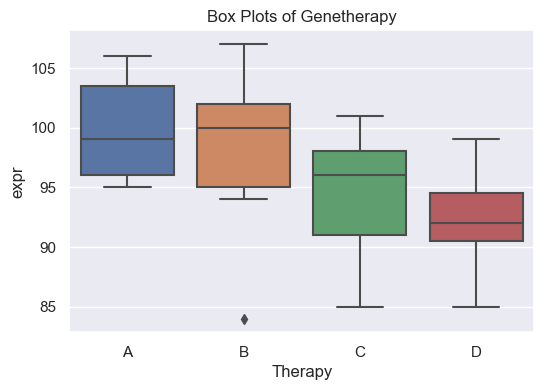

In [15]:
sns.set(style="darkgrid")
fig1 = plt.figure(dpi=100)
sns.boxplot(x='Therapy', y='expr', data=df)
plt.title('Box Plots of Genetherapy')

Построенные боксплоты показывают медианные значения и "объем" данных, входящих в границы 1,5 межквартильных расстояний. Такие графики удобны для определения выбросов, которые могут повлиять на нормальность распределения. Как видим, в данных для терапии типа В есть один выброс, нужно будет быть внимательным при проверке.
Построим графики qq-plot.

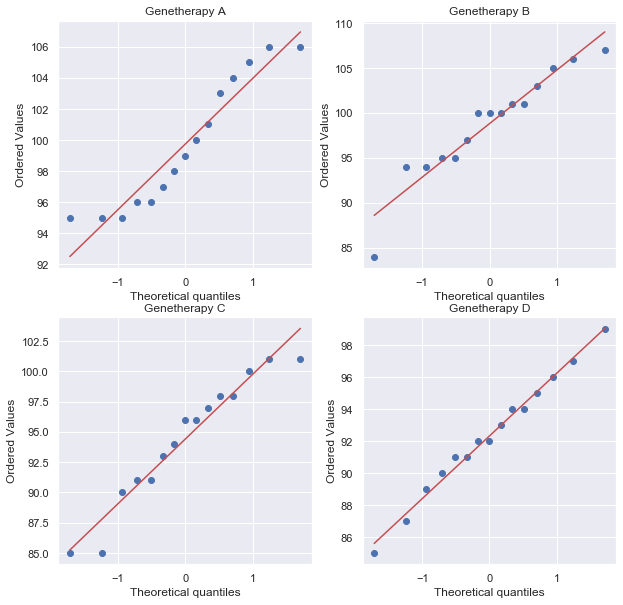

In [49]:
a = df[df['Therapy'] == 'A']['expr']
b = df[df['Therapy'] == 'B']['expr']
c = df[df['Therapy'] == 'C']['expr']
d = df[df['Therapy'] == 'D']['expr']
dataset = [a, b, c, d]
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
names = df.Therapy.unique()
k = 0
for i in range(2):
    for j in range(2):
        stats.probplot(dataset[k], plot=axes[i][j], dist=stats.t(dataset[k]))
        axes[i][j].set_title(label='Genetherapy ' + names[k])
        k += 1

В целом, данные t-распределения близки к нормальным, опять же, есть значения, выбивающиеся из нормального распределения, но насколько это критично выясним с помощью теста Шапиро-Уилка.

In [6]:
sh_test = [stats.shapiro(x) for x in dataset]
sh_test

[(0.887749969959259, 0.062011588364839554),
 (0.9259758591651917, 0.23740161955356598),
 (0.9287736415863037, 0.2615790367126465),
 (0.9913022518157959, 0.999784529209137)]

Во всех распределениях р-уровень значимости(2-е значение) выше 0,05 (хотя для терапии А результат на грани), а значит наши выборки действительно принадлежат к совокупности с нормальным распределением и дальнейший анализ можно проводить не опасаясь. Выполним однофакторный дисперсионный анализ.

In [7]:
stats.f_oneway(*dataset)

F_onewayResult(statistic=8.03730248114399, pvalue=0.00015249722895229536)

Мы получили F-значение примерно 8.04 и p-уровень значимости гораздо ниже 0,05. Значит можно смело отклонять нулевую гипотезу, и сделать вывод о том, что как минимум между 2-я группами есть статистически значимые различия.

Text(0.5, 1.0, 'Means and intervals')

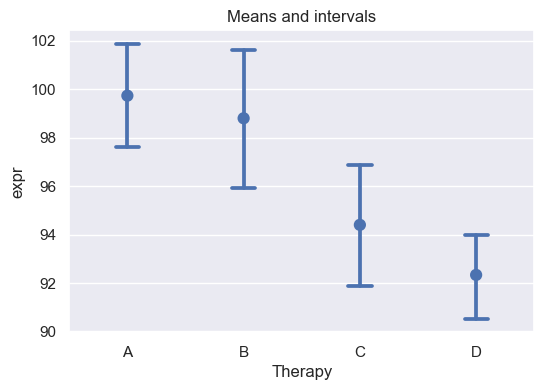

In [8]:
fig3 = plt.figure(dpi=100)
sns.pointplot(x="Therapy", y="expr", data=df, capsize=.2, join=False)
plt.title(label='Means and intervals')

Группа терапии A и B гораздо лучше справляется с повышением экспрессии гена. Даже не проводя множественный анализ, можно предположить, что терапия А дает статистически значимые результаты по сравнению с группами C и D, так как её среднее не входит в доверительные интервалы этих групп, и наоборот. Тем не менее, произведем множественные сравнения по следующему плану:
1. Попарно сравним по t-критерию все группы, применив поправку Бонферрони к р-уровню значимости.
2. Применим критерий Тьюки к множественному сравнению.

In [17]:
n = (4 * (4 - 1)) / 2 # Количество попарных сравнений.
p_val = 0.05 / n      # Новый уровень p-значимости для сравнения.
_, a_b = stats.ttest_ind(a, b)
_, a_c = stats.ttest_ind(a, c)
_, a_d = stats.ttest_ind(a, d)
_, b_c = stats.ttest_ind(b, c)
_, b_d = stats.ttest_ind(b, d)
_, c_d = stats.ttest_ind(c, d)
group_names = ['A-B', 'A-C', 'A-D', 'B-C', 'B-D', 'C-D']
data_test = [a_b, a_c, a_d, b_c, b_d, c_d]
new_p = ['{:.3f}'.format(x / p_val) for x in data_test]
bool_res = [float(x) < 0.05 for x in new_p] 
testFrame = pd.DataFrame(data={'Groups': group_names, 'p-value': new_p, 'Test': bool_res})
testFrame

,Groups,p-value,Test
0,A-B,74.449,False
1,A-C,0.522,False
2,A-D,0.002,True
3,B-C,4.645,False
4,B-D,0.150,False
5,C-D,26.546,False


Как видим, поправка Бонферрони очень жесткая и отсеяла все сравнения, кроме одного гарантированно значимого. Если мы вернемся к графику доверительных интервалов, то, действительно, доверительные интервалы групп A и D наиболее далеки друг от друга. Попробуем применить более мягкую поправку Тьюки.

In [69]:
from statsmodels.stats.multicomp import MultiComparison
data = MultiComparison(df['expr'], df['Therapy'])
results = data.tukeyhsd()
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.9333,0.9,-5.5961,3.7294,False
A,C,-5.3333,0.0189,-9.9961,-0.6706,True
A,D,-7.4,0.001,-12.0628,-2.7372,True
B,C,-4.4,0.0712,-9.0628,0.2628,False
B,D,-6.4667,0.0029,-11.1294,-1.8039,True
C,D,-2.0667,0.6296,-6.7294,2.5961,False


Более мягкая поправка Тьюки дает уже больше статистически значимых результатов. Так, статистически значимы пары терапии А-C, A-D, B-D. Результаты согласуются с резульатами, полученными в уроке.

# Урок 2.6. Двухфакторный дисперсионный анализ.

Данный урок посвящен многофакторному anova. В первом примере рассмотрена взаиосвязь экспрессии гена в зависимости от дозировки лекарства и возраста пациентов. Проверять распределение на нормальность нет смысла, так как в учебных примерах подобраны нормально-распределенные выборки.

*В предыдущем шаге я это делал больше для демонстрации и закрепления навыков.

In [10]:
df_ath = pd.read_csv('atherosclerosis.csv')
df_ath.head()

,expr,age,dose
0,107.351478,1,D1
1,104.504438,1,D1
2,103.435134,1,D1
3,109.572882,1,D1
4,114.993803,1,D1


Сделаем таблицу более информативной.

In [11]:
df_ath['age'].replace(1, 'Young', inplace=True)
df_ath['age'].replace(2, 'Old', inplace=True)
df_ath['dose'].replace('D1', 'Low dose', inplace=True)
df_ath['dose'].replace('D2', 'High dose', inplace=True)
df_ath.head()

,expr,age,dose
0,107.351478,Young,Low dose
1,104.504438,Young,Low dose
2,103.435134,Young,Low dose
3,109.572882,Young,Low dose
4,114.993803,Young,Low dose


In [12]:
age_dose_desc = df_ath.groupby(['age', 'dose']).describe()
age_dose_desc

expr                                               \
                count        mean       std        min         25%   
age   dose                                                           
Old   High dose  16.0  102.273629  5.135374  94.180214   98.843173   
      Low dose   16.0  101.004805  5.116310  90.970949   98.257464   
Young High dose  16.0  105.545864  4.369024  94.554612  104.343822   
      Low dose   16.0  104.758464  5.863454  90.918788  102.769657   

                                                     
                        50%         75%         max  
age   dose                                           
Old   High dose  101.875234  104.445248  111.639129  
      Low dose   100.912804  104.012453  112.008916  
Young High dose  106.550749  107.736334  111.552090  
      Low dose   104.779105  107.147066  114.993803

Дисперсионный анализ выполним, взяв соответствующую функцию из пакета statsmodel.

In [13]:
from statsmodels.stats.anova import anova_lm
sum_lm = smf.ols('expr ~ age + dose', data=df_ath).fit()
anova_lm(sum_lm)

,df,sum_sq,mean_sq,F,PR(>F)
age,1.0,197.452754,197.452754,7.569592,0.007804
dose,1.0,16.912241,16.912241,0.648351,0.423830
Residual,61.0,1591.184501,26.084992,NaN,NaN


Вывод по данному анализу можно сделать такой: значимого эффекта на уровень экспрессии гена оказывает возраст (р < 0.05), но не дозировка. Взглянув на график ниже, очевидно, что именно более молодые пациенты независимо от дозировки лекарства имели среднее значение экспрессии гена выше, чем пожилые.

Text(0.5, 1.0, 'Gene expression depending on the dosage of the drug\nand the age of the patients')

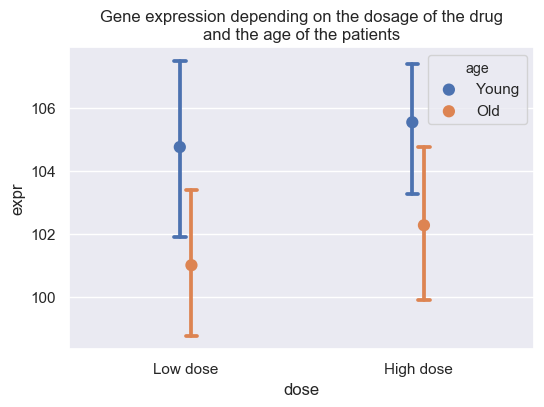

In [14]:
fig4 = plt.figure(dpi=100)
sns.pointplot(x='dose', y='expr', hue='age', capsize=.05,
              data=df_ath, dodge=True, join=False)
plt.title(label='Gene expression depending on the dosage of the drug\nand the age of the patients')

Далее в уроке рассматривалось взаимодействие факторов, для чего искусственно завысим в таблице экспрессию для более высокой дозировки.

In [19]:
df_ath.loc[df_ath['dose'] == 'High dose', 'expr'] += 5

Text(0.5, 1.0, 'Gene expression depending on the dosage of the drug\nand the age of the patients')

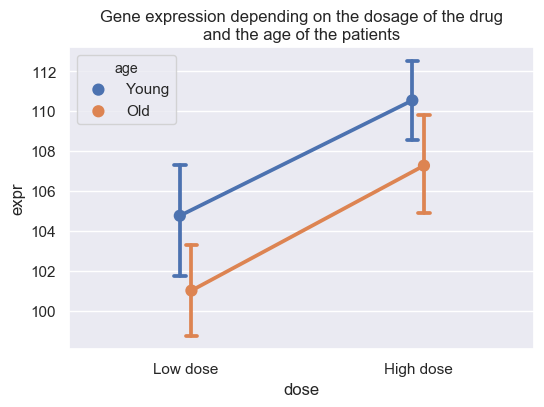

In [20]:
fig5 = plt.figure(dpi=100)
sns.pointplot(x='dose', y='expr', hue='age', capsize=.05,
              data=df_ath, dodge=True)
plt.title(label='Gene expression depending on the dosage of the drug\nand the age of the patients')

Теперь же мы видим совершенно иную картину: на уровень экспрессии гена оказывает влияние как возраст пациентов, так и дозировка лекарства. Однако, мы не можем однозначно заявлять, что все 4 группы в данном примере значимо различаются между собой, пока мы не проведем множественное сравнение с поправкой и не выясним, какие именно пары групп статистически значимы.

В следующих степах этого урока рассматривалось взаимодействие двух факторов на примере исследования влияния инъекции некоторого гормона на уровень кальция в крови птиц в зависимости от их пола.

In [21]:
df_birds = pd.read_csv('birds.csv')
df_birds['sex'].replace(1, 'Male', inplace=True)
df_birds['sex'].replace(0, 'Female', inplace=True)
df_birds['hormone'].replace(1, 'Inject Yes', inplace=True)
df_birds['hormone'].replace(0, 'Inject No', inplace=True)
df_birds.head()

,var4,hormone,sex
0,17.859039,Inject Yes,Male
1,20.842343,Inject Yes,Male
2,19.318099,Inject Yes,Male
3,20.064451,Inject Yes,Male
4,17.620316,Inject Yes,Male


Выполним двухфакторный анализ с учетом взаимосвязи.

In [22]:
sum_lm = smf.ols('var4 ~ hormone + sex + hormone * sex', data=df_birds).fit()
anova_lm(sum_lm)

,df,sum_sq,mean_sq,F,PR(>F)
hormone,1.0,0.847472,0.847472,0.086528,0.769653
sex,1.0,0.119762,0.119762,0.012228,0.912318
hormone:sex,1.0,89.483384,89.483384,9.136390,0.003682
Residual,60.0,587.650394,9.794173,NaN,NaN


Text(0.5, 1.0, 'Effect of injection on var4 level by gender')

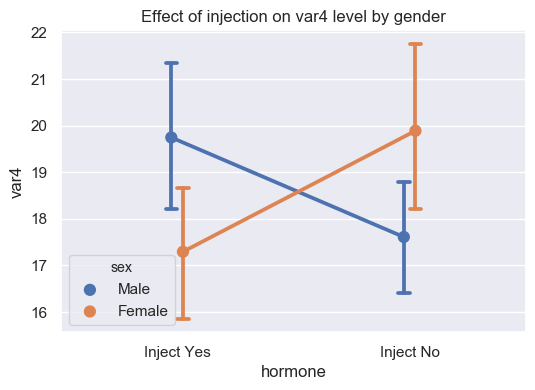

In [23]:
fig6 = plt.figure(dpi=100)
sns.pointplot(x='hormone', y='var4', hue='sex', capsize=.05,
              data=df_birds, dodge=True)
plt.title(label='Effect of injection on var4 level by gender')

На данном графике хорошо иллюстрируется взаимодействие факторов и их влияние на зависимую переменную var4 (р-уровень значимости меньше 0.05 только для взаимодействия). Уровень var4 повышается у самцов при инъекции гормона, а у самок наоборот, при её отсутствии.

# Урок 3.3. Регрессия с одной независимой переменной.

В данном уроке предлагается проанализировать взаимосвязь уровня образования на уровень бедности в штатах США.

In [24]:
df_states = pd.read_csv('states.csv')
df_states.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.4,71.3,79.9,14.6,14.2
1,Alaska,65.6,70.8,90.6,8.3,10.8
2,Arizona,88.2,87.7,83.8,13.3,11.1
3,Arkansas,52.5,81.0,80.9,18.0,12.1
4,California,94.4,77.5,81.1,12.8,12.6


В колонках указаны доли в процентах жителей, проживающих в столичном регионе, процент белого населения, процент граждан с высшим образованием, уровень бедности и процент семей, в которых женщины являются домохозяйками. В данном уроке зависимой переменной выбран уровень бедности, а независимой - уровень образования. Для начала построим диаграмму рассеивания.

Text(0.5, 1.0, 'The relationship between poverty and education')

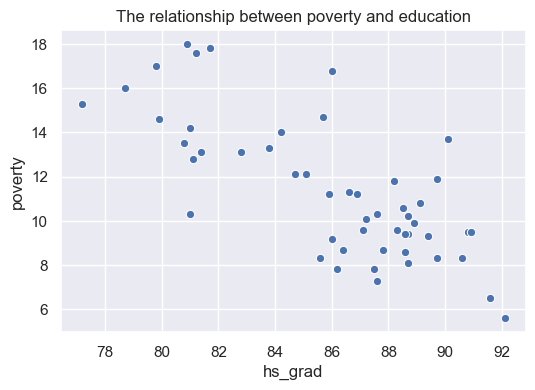

In [25]:
fig7 = plt.figure(dpi=100)
sns.scatterplot(x="hs_grad", y="poverty", data=df_states)
plt.title(label='The relationship between poverty and education')

Видно, что в целом взаимосвязь является линейной отрицательной. Регрессионный анализ выполним по следующему плану:
1. Расчитаем уравнение для регрессионной прямой, т.е. построим модель.
2. Определим, какая часть зависимой переменной обуславливается независимой переменной, определив коэффиициент детерминации. Заодно, опровергнем (или подтвердим) нулевую гипотезу об отсутствии взаимосвязи переменных.
3. Сделаем предсказание на основе полученной статистической модели.

In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_states.hs_grad, df_states.poverty)
regressTable = pd.DataFrame(data = {'Intercept': intercept, 'hs_grad': slope, 'Correlation': r_value, 'p-value': p_value,
                                    'Std.Error': std_err}, index = [0])
regressTable

,Intercept,hs_grad,Correlation,p-value,Std.Error
0,64.780966,-0.621217,-0.746858,3.108830e-10,0.079016


Text(0.5, 1.0, 'The relationship between poverty and education')

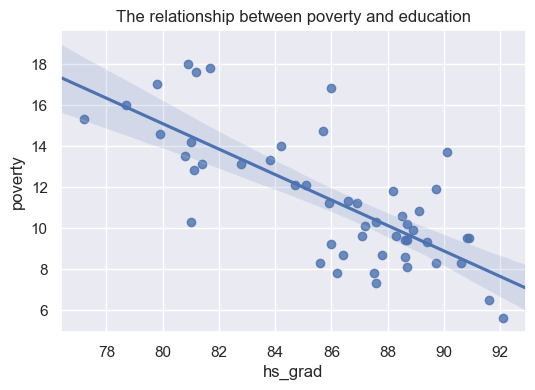

In [27]:
fig8 = plt.figure(dpi=100)
sns.regplot(x="hs_grad", y="poverty", data=df_states)
plt.title(label = 'The relationship between poverty and education')

Итоговое уровнение для изображенной выше регрессионной прямой будет иметь вид:

poverty = 64.78 - 0.62 * hs_grad

Данное уравнение говорит о том, что: во-первых, зависимость отрицательная, на что указывает аргумент slope, во-вторых, мы получили так же р-уровень значимости гораздо ниже 0.05, что говорит о том, что можно смело отклонить нулевую гипотезу и подтвердить наличие отрицательной взаимосвязи двух переменных. Кроме того, полученный коэффициент детерминации R = 0,75^2 = 0.55 говорит о том, что только примерно половина значений зависимой переменной обуславливается влиянием независимой переменной. А значит можно рассмотреть влияние нескольких факторов, но об этом позже.

Для оценки адекватности регрессионной модели остатки зависимой переменной (расстояния от фактического значения до предсказанного) должны распределяться нормальным образом. Так, на графике рассеяния остатков относительно среднего значения видно, что в целом, остатки распределены равномерно на всем протяжении независимой переменной.

Text(0.5, 1.0, 'Residue analysis')

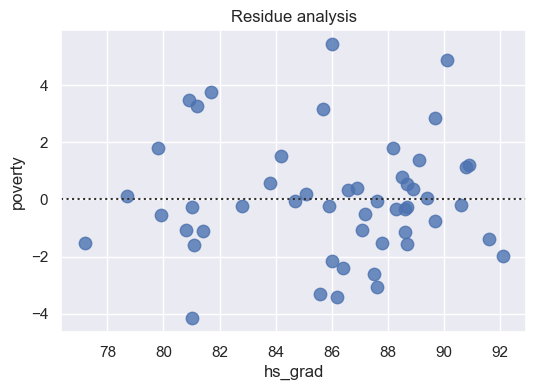

In [28]:
fig9 = plt.figure(dpi=100)
sns.residplot(x="hs_grad", y="poverty", data=df_states, scatter_kws={"s": 80});
plt.title(label = 'Residue analysis')

Для проверки распределения построим график qq-plot, предварительно вычислив остатки.

Text(0.5, 1.0, 'Residue analysis QQ-Plot')

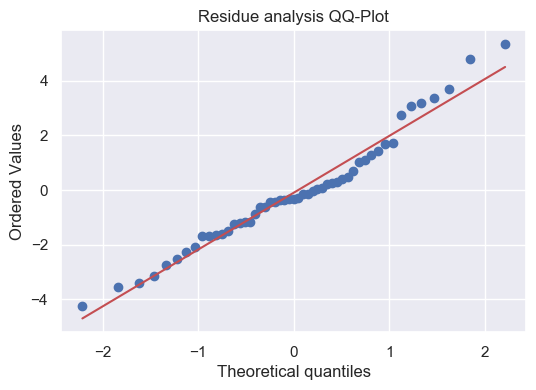

In [29]:
df_states['data_res'] = df_states['poverty'] - 64.78 + 0.62 * df_states['hs_grad']
residuals = df_states.loc[:, 'data_res']
fig10 = plt.figure(dpi = 100)
stats.probplot(residuals, plot=plt)
plt.title(label = 'Residue analysis QQ-Plot')

Остатки распределены нормально за искллючением некоторых минимальных и максимальных значений, а значит применение регрессионного анализа было обоснованным. Следовательно, модель надежна и мы можем выполнить предсказание.
Предсказательные возможности такого анализа говорят о том, что при увеличении уровня высшего образования на один процент ожидается снижение уровня бедности на 0.62 процента. Например, если мы прогнозируем повышение уровня образования до 97 процентов, то ожидаемый уровень бедности можно определить по линии тренда, нанеся точку со значением х = 97 прямо на нее, либо рассчитав вручную.

poverty = 64.78 - 0.62 * 97 = 4.64.

## Урок 3.9. Множественная регрессия. Выбор модели.

Основная идея выбора модели для множественной регрессии заключается в том, чтобы максимизировать коэффициент детерминации, т.е. взаимосвязь нескольких переменных. Проблема в том, что некоторые переменные могут наоборот уменьшать этот коэффициент, оттягивая на себя корреляцию с другими переменными. Исключить такие переменные можно добавив сначала все переменные в модель, а затем удаляя оттуда поочередно независимые переменные и выбирая для дальнейшего анализа ту модель, коэффициент детерминации которой максимален. Итак, первый шаг тогда будет следующим: 

In [30]:
mod = smf.ols(formula='poverty ~ hs_grad + white + metro_res + female_house', data=df_states)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           8.88e-10
Time:                        20:35:07   Log-Likelihood:                -103.39
No. Observations:                  51   AIC:                             216.8
Df Residuals:                      46   BIC:                             226.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.4765     12.590      5.280      0.000      41.134      91.819
hs_grad         -0.5547      0.105     -5.288      0.000      -0.766      -0.344
white           -0.0481      0.033     -1.456      0.152      -0.115       0.018
metro_res       -0.0563      0.020     -2.881      0.006      -0.096      -0.017
female_house     0.0505      0.243      0.208      0.836      -0.439       0.540
==============================================================================
Omnibus:                        3.254   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.043
Skew:                           0.585   Prob(JB):                        0.218
Kurtosis:                       2.750   Cond. No.                     6.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Исправленный R квадрат равен 0.61. Кроме того, в таблице можно сразу определить переменную, которую стоит попробовать исключить, так как р-уровень значимости для нее слишком высок.

In [31]:
mod = smf.ols(formula='poverty ~ hs_grad + white + metro_res', data=df_states)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     28.00
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           1.55e-10
Time:                        20:35:34   Log-Likelihood:                -103.41
No. Observations:                  51   AIC:                             214.8
Df Residuals:                      47   BIC:                             222.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.7220      6.389     10.756      0.000      55.869      81.575
hs_grad       -0.5697      0.075     -7.569      0.000      -0.721      -0.418
white         -0.0533      0.021     -2.483      0.017      -0.097      -0.010
metro_res     -0.0555      0.019     -2.926      0.005      -0.094      -0.017
==============================================================================
Omnibus:                        3.479   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.230
Skew:                           0.607   Prob(JB):                        0.199
Kurtosis:                       2.787   Cond. No.                     3.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Исключив переменную 'female_house', во-первых, увеличился коэффициент детерминации, во вторых, существенно уменьшился р-уровень значимости для переменной 'white' и ее исключать далее не обязательно и, в-третьих, коэффициенты slope для всех независимых переменных увеличились. Все это подтверждает гипотезу о том, что переменная 'female_house' значительно коррелировала с другими независимыми переменными, но оказывала слабое и даже вредное влияние на зависимую переменную.

Чтобы не загромождать проект, дальнейший выбор модели проводить нет смысла, так как полученная модель уже является оптимальной, как и было показано в лекциях. Напоследок можно написать итоговую формулу для зависимой переменной:

poverty = 68.72 - 0.57 * hs_grad - 0.53 * white - 0.55 * metro_res

Предсказательная возможность данной формулы говорит о том, что при уменьшении на единичное значение или один процент независимой переменной уровня образования при условии неизменности прочих переменных, уровень бедности ожидаемо уменьшится на 0.57 процента. Аналогично для остальных переменных.